<a href="https://colab.research.google.com/github/joncalle/ML2/blob/main/Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install rfpimp
!pip install category_encoders

  Preparing metadata (setup.py) ... done
  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10649 sha256=1c42d973284ffa156079ea250567518f7dea71e1cd98da39ee7bbc88b1419a16
  Stored in directory: /root/.cache/pip/wheels/6a/12/08/d5bc35127c8d69d39c1f3736a95419ab4763cc0c80ed65bf41
Successfully built rfpimp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.5 MB/s eta 0:00:00


In [20]:
import numpy as np
import pandas as pd
import warnings
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_string_dtype
import category_encoders as ce
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from rfpimp import *

In [55]:
def evaluate(X, y, n_estimators=150):
    oob_scores = []
    r2 = []
    for i in range(10):
        rf = RandomForestRegressor(n_estimators=n_estimators, n_jobs=-1, oob_score=True)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        rf.fit(X_train, y_train)
        oob_scores.append(rf.oob_score_)
        r2.append(rf.score(X_train, y_train))
        n = rfnnodes(rf)
        h = np.median(rfmaxdepths(rf))
    avg_oob = sum(oob_scores) / len(oob_scores)
    avg_r2 = sum(r2) / len(r2)
    print("Number of trees:",n_estimators)
    print(f"Average OOB score over 10 runs for baseline model is: {avg_oob:.4f}")
    print(f"Average of R^2 over 10 runs for model_2 is: {avg_r2:.4f}")
    return rf, avg_oob

def showimp(rf, X, y):
    features = list(X.columns)
    I = importances(rf, X, y, features=features)
    plot_importances(I, color='silver')

def sniff_modified(df):
    with pd.option_context("display.max_colwidth", 20):
        info = pd.DataFrame()
        info['data type'] = df.dtypes
        info['percent missing'] = df.isnull().sum()*100/len(df)
        info['No. unique'] = df.apply(lambda x: len(x.unique()))
        info['unique values'] = df.apply(lambda x: x.unique())
        return info.sort_values('data type')

def df_normalize_strings(df, patt):
    for col in df.columns:
        if is_string_dtype(df[col]) or is_object_dtype(df[col]):
            df[col] = df[col].str.lower()
            df[col] = df[col].fillna(np.nan)
            df[col] = df[col].replace(patt, np.nan)

def df_string_to_cat(df):
    for col in df.columns:
        if is_string_dtype(df[col]):
            df[col] = df[col].astype('category').cat.as_ordered()

def df_cat_to_catcode(df):
    for col in df.columns:
        if is_categorical_dtype(df[col]):
            df[col] = df[col].cat.codes + 1

# Filling the missing values with median
def fix_missing_num(df, colname):
    df[colname].fillna(df[colname].median(), inplace=True)

In [33]:
chr = pd.read_csv("https://raw.githubusercontent.com/joncalle/ML2/main/ChurnData.csv")
chr = chr.drop(['CustomerID'], axis=1) # CustomerID is an ID/Secuential info, it is not need it.
print(chr.shape) # print rows, columns
chr.head(10).T   # dump first 2 rows

(5630, 19)


,0,1,2,3,4,5,6,7,8,9
Churn,1,1,1,1,1,1,1,1,1,1
Tenure,4.0,NaN,NaN,0.0,0.0,0.0,NaN,NaN,13.0,NaN
PreferredLoginDevice,Mobile Phone,Phone,Phone,Phone,Phone,Computer,Phone,Phone,Phone,Phone
CityTier,3,1,1,3,1,1,3,1,3,1
WarehouseToHome,6.0,8.0,30.0,15.0,12.0,22.0,11.0,6.0,9.0,31.0
PreferredPaymentMode,Debit Card,UPI,Debit Card,Debit Card,CC,Debit Card,Cash on Delivery,CC,E wallet,Debit Card
Gender,Female,Male,Male,Male,Male,Female,Male,Male,Male,Male
HourSpendOnApp,3.0,3.0,2.0,2.0,NaN,3.0,2.0,3.0,NaN,2.0
NumberOfDeviceRegistered,3,4,4,4,3,5,3,3,4,5
PreferedOrderCat,Laptop & Accessory,Mobile,Mobile,Laptop & Accessory,Mobile,Mobile Phone,Laptop & Accessory,Mobile,Mobile,Mobile


In [30]:
#verify there are no missing values
chr.isna().sum()

Churn                            0
Tenure                         264
PreferredLoginDevice             0
CityTier                         0
WarehouseToHome                251
PreferredPaymentMode             0
Gender                           0
HourSpendOnApp                 255
NumberOfDeviceRegistered         0
PreferedOrderCat                 0
SatisfactionScore                0
MaritalStatus                    0
NumberOfAddress                  0
Complain                         0
OrderAmountHikeFromlastYear    265
CouponUsed                     256
OrderCount                     258
DaySinceLastOrder              307
CashbackAmount                   0
dtype: int64

In [31]:
sniff_modified(chr)

,data type,percent missing,No. unique,unique values
Churn,int64,0.000000,2,"[1, 0]"
Complain,int64,0.000000,2,"[1, 0]"
NumberOfAddress,int64,0.000000,15,"[9, 7, 6, 8, 3, 2, 4, 10, 1, 5, 19, 21, 11, 20..."
SatisfactionScore,int64,0.000000,5,"[2, 3, 5, 4, 1]"
NumberOfDeviceRegistered,int64,0.000000,6,"[3, 4, 5, 2, 1, 6]"
CashbackAmount,int64,0.000000,220,"[160, 121, 120, 134, 130, 139, 123, 127, 295, ..."
CityTier,int64,0.000000,3,"[3, 1, 2]"
HourSpendOnApp,float64,4.529307,7,"[3.0, 2.0, nan, 1.0, 0.0, 4.0, 5.0]"
WarehouseToHome,float64,4.458259,35,"[6.0, 8.0, 30.0, 15.0, 12.0, 22.0, 11.0, 9.0, ..."
DaySinceLastOrder,float64,5.452931,23,"[5.0, 0.0, 3.0, 7.0, 2.0, 1.0, 8.0, 6.0, 4.0, ..."


In [45]:
#convert all non-numeric features to numeric
patt = ['unknown','xxxxx','   ']
warnings.filterwarnings('ignore')
chr_str = chr.select_dtypes(include=[object])

df_normalize_strings(chr_str, patt)
df_string_to_cat(chr_str)
df_cat_to_catcode(chr_str)
sniff_modified(chr_str)

,data type,percent missing,No. unique,unique values
PreferredLoginDevice,int8,0.0,3,"[2, 3, 1]"
PreferredPaymentMode,int8,0.0,7,"[5, 7, 2, 1, 6, 3, 4]"
Gender,int8,0.0,2,"[1, 2]"
PreferedOrderCat,int8,0.0,6,"[3, 4, 5, 6, 1, 2]"
MaritalStatus,int8,0.0,3,"[3, 1, 2]"


In [46]:
chr_num = chr.select_dtypes(include=[np.number])
chr_num = chr_num.drop(['Churn'], axis=1)

# Filling the missing values with median
for column_name in chr_num.columns:
    print(column_name)
    fix_missing_num(chr_num, column_name)

Tenure
CityTier
WarehouseToHome
HourSpendOnApp
NumberOfDeviceRegistered
SatisfactionScore
NumberOfAddress
Complain
OrderAmountHikeFromlastYear
CouponUsed
OrderCount
DaySinceLastOrder
CashbackAmount


In [47]:
chr_new = pd.concat([chr_str, chr_num], axis=1)

In [48]:
chr_new.isnull().sum()

PreferredLoginDevice           0
PreferredPaymentMode           0
Gender                         0
PreferedOrderCat               0
MaritalStatus                  0
Tenure                         0
CityTier                       0
WarehouseToHome                0
HourSpendOnApp                 0
NumberOfDeviceRegistered       0
SatisfactionScore              0
NumberOfAddress                0
Complain                       0
OrderAmountHikeFromlastYear    0
CouponUsed                     0
OrderCount                     0
DaySinceLastOrder              0
CashbackAmount                 0
dtype: int64

In [50]:
for col in chr_new:
  print(chr_new[col].unique())

[2 3 1]
[5 7 2 1 6 3 4]
[1 2]
[3 4 5 6 1 2]
[3 1 2]
[ 4.  9.  0. 13. 11. 19. 20. 14.  8. 18.  5.  2. 30.  1. 23.  3. 29.  6.
 26. 28.  7. 24. 25. 10. 15. 22. 27. 16. 12. 21. 17. 50. 60. 31. 51. 61.]
[3 1 2]
[  6.   8.  30.  15.  12.  22.  11.   9.  31.  18.  13.  20.  29.  28.
  26.  14.  10.  27.  17.  23.  33.  19.  35.  24.  16.  25.  32.  34.
   5.  21. 126.   7.  36. 127.]
[3. 2. 1. 0. 4. 5.]
[3 4 5 2 1 6]
[2 3 5 4 1]
[ 9  7  6  8  3  2  4 10  1  5 19 21 11 20 22]
[1 0]
[11. 15. 14. 23. 22. 16. 12. 13. 17. 18. 24. 19. 20. 21. 25. 26.]
[ 1.  0.  4.  2.  9.  6. 11.  7. 12. 10.  5.  3. 13. 15.  8. 14. 16.]
[ 1.  6.  2. 15.  4.  7.  3.  9. 11.  5. 12. 10.  8. 13. 14. 16.]
[ 5.  0.  3.  7.  2.  1.  8.  6.  4. 15.  9. 11. 10. 13. 12. 17. 16. 14.
 30. 46. 18. 31.]
[160 121 120 134 130 139 123 127 295 154 196 129 157 161 150 162 203 117
 146 207 142 173 190 143 133 209 122 194 126 299 125 187 131 111 205 137
 145 128 290 287 195 237 300 159 268 136 144 153 166 163 168 138 167 176
 149 204

In [51]:
sniff_modified(chr_new)

,data type,percent missing,No. unique,unique values
PreferredLoginDevice,int8,0.0,3,"[2, 3, 1]"
PreferredPaymentMode,int8,0.0,7,"[5, 7, 2, 1, 6, 3, 4]"
Gender,int8,0.0,2,"[1, 2]"
PreferedOrderCat,int8,0.0,6,"[3, 4, 5, 6, 1, 2]"
MaritalStatus,int8,0.0,3,"[3, 1, 2]"
Complain,int64,0.0,2,"[1, 0]"
NumberOfAddress,int64,0.0,15,"[9, 7, 6, 8, 3, 2, 4, 10, 1, 5, 19, 21, 11, 20..."
SatisfactionScore,int64,0.0,5,"[2, 3, 5, 4, 1]"
NumberOfDeviceRegistered,int64,0.0,6,"[3, 4, 5, 2, 1, 6]"
CashbackAmount,int64,0.0,220,"[160, 121, 120, 134, 130, 139, 123, 127, 295, ..."


In [54]:
X1, y1 = chr_new, chr[['Churn']]
rf, oob = evaluate(X1, y1)

Number of trees: 150
Average OOB score over 10 runs for baseline model is: 0.7936
Average of R^2 over 10 runs for model_2 is: 0.9719


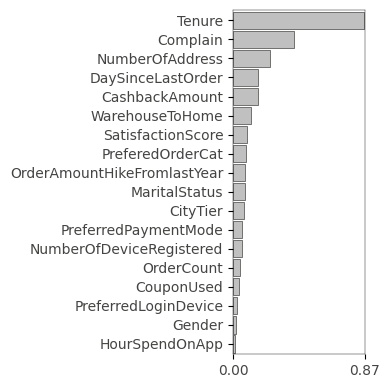

In [56]:
showimp(rf, X1, y1)